## NYC Taxi Trip Duration Prediction - Problem Statement

At some point or the other almost each one of us has used an Ola or Uber for taking a ride. 

Ride hailing services are services that use online-enabled platforms to connect between passengers and local drivers using their personal vehicles. In most cases they are a comfortable method for door-to-door transport. Usually they are cheaper than using licensed taxicabs. Examples of ride hailing services include Uber and Lyft.

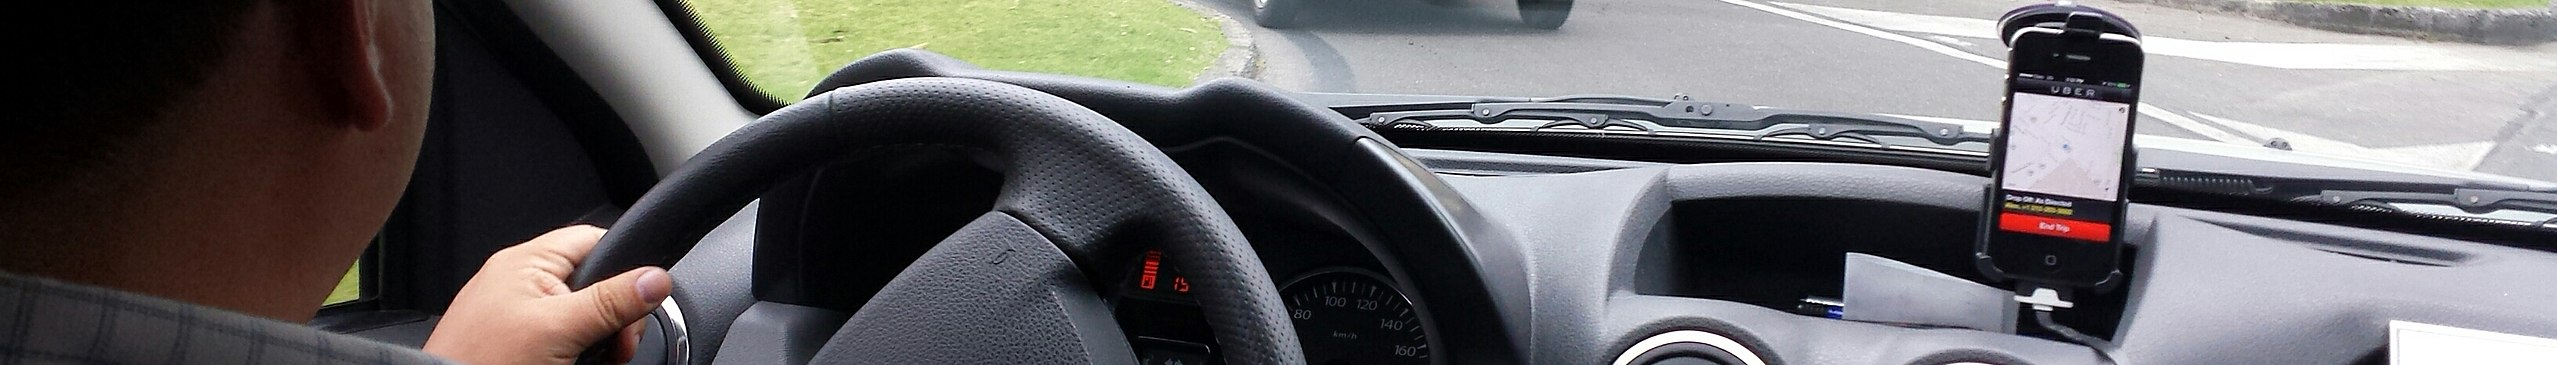

To improve the efficiency of taxi dispatching systems for such services, it is important to be able to predict how long a driver will have his taxi occupied. If a dispatcher knew approximately when a taxi driver would be ending their current ride, they would be better able to identify which driver to assign to each pickup request.

In this competition, we are challenged to build a model that predicts the total ride duration of taxi trips in New York City.

## 1. Exploratory Data Analysis
Let's check the data files! According to the data description we should find the following columns:

 - **id** - a unique identifier for each trip
 - **vendor_id** - a code indicating the provider associated with the trip record
 - **pickup_datetime** - date and time when the meter was engaged
 - **dropoff_datetime** - date and time when the meter was disengaged
 - **passenger_count** - the number of passengers in the vehicle (driver entered value)
 - **pickup_longitude** - the longitude where the meter was engaged
 - **pickup_latitude** - the latitude where the meter was engaged
 - **dropoff_longitude** - the longitude where the meter was disengaged
 - **dropoff_latitude** - the latitude where the meter was disengaged
 - **store_and_fwd_flag** - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server (Y=store and forward; N=not a store and forward trip)
 - **trip_duration** - (target) duration of the trip in seconds

Here, we have 2 variables dropoff_datetime and store_and_fwd_flag which are not available before the trip starts and hence will not be used as features to the model.

### 1.1 Load Libraries

In [14]:
%matplotlib inline
import numpy as np 
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import xgboost as xgb

### Load Data

In [2]:
df = pd.read_csv('nyc_taxi_trip_duration.csv')

### File structure and content

In [4]:
print('We have {} rows.'.format(df.shape[0]))
print('We have {} columns'.format(df.shape[1]))
df.iloc[1,:]

We have 729322 rows.
We have 11 columns


id                              id0889885
vendor_id                               1
pickup_datetime       2016-03-11 23:35:37
dropoff_datetime      2016-03-11 23:53:57
passenger_count                         2
pickup_longitude                 -73.9883
pickup_latitude                   40.7317
dropoff_longitude                -73.9948
dropoff_latitude                  40.6949
store_and_fwd_flag                      N
trip_duration                        1100
Name: 1, dtype: object

In [5]:
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id1080784,2,2016-02-29 16:40:21,2016-02-29 16:47:01,1,-73.953918,40.778873,-73.963875,40.771164,N,400
1,id0889885,1,2016-03-11 23:35:37,2016-03-11 23:53:57,2,-73.988312,40.731743,-73.994751,40.694931,N,1100
2,id0857912,2,2016-02-21 17:59:33,2016-02-21 18:26:48,2,-73.997314,40.721458,-73.948029,40.774918,N,1635
3,id3744273,2,2016-01-05 09:44:31,2016-01-05 10:03:32,6,-73.961670,40.759720,-73.956779,40.780628,N,1141
4,id0232939,1,2016-02-17 06:42:23,2016-02-17 06:56:31,1,-74.017120,40.708469,-73.988182,40.740631,N,848


In [6]:
df.dtypes

id                     object
vendor_id               int64
pickup_datetime        object
dropoff_datetime       object
passenger_count         int64
pickup_longitude      float64
pickup_latitude       float64
dropoff_longitude     float64
dropoff_latitude      float64
store_and_fwd_flag     object
trip_duration           int64
dtype: object

At first glance, we can see the types of each variable and what they look like. 

### Missing Values
Knowing about missing values is important because they indicate how much we don’t know about our data. Making inferences based on just a few cases is often unwise. In addition, many modelling procedures break down when missing values are involved and the corresponding rows will either have to be removed completely or the values need to be estimated somehow.

In [7]:
np.sum(pd.isnull(df))

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

Fortunately, in this dataset we do not have any missing values which is great.

### Reformatting features & Checking consistency
There are a variety of features within the dataset and it is important to convert them into the right format such that we can analyse them easily. This would include converting datetime features and string features. 

Also, one important thing is never to take assumptions without backing it with data. Here, as you can see the trip duration can also be calculated with pick up and drop off datetime values. We will check whether the given duration is consistent with the calculated trip duration 

### DateTime Conversion
The datetime features from csv files are read as strings and in order to easily extract features like day of week, month, year etc., we need to convert them into datetime format of Python.

In [8]:
# converting strings to datetime features
df['pickup_datetime'] = pd.to_datetime(df.pickup_datetime)
df['dropoff_datetime'] = pd.to_datetime(df.dropoff_datetime)

# Converting yes/no flag to 1 and 0
df['store_and_fwd_flag'] = 1 * (df.store_and_fwd_flag.values == 'Y')

df['check_trip_duration'] = (df['dropoff_datetime'] - df['pickup_datetime']).map(lambda x: x.total_seconds())

duration_difference = df[np.abs(df['check_trip_duration'].values  - df['trip_duration'].values) > 1]
duration_difference.shape

(0, 12)

In [11]:
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,check_trip_duration
0,id1080784,2,2016-02-29 16:40:21,2016-02-29 16:47:01,1,-73.953918,40.778873,-73.963875,40.771164,0,400,400.0
1,id0889885,1,2016-03-11 23:35:37,2016-03-11 23:53:57,2,-73.988312,40.731743,-73.994751,40.694931,0,1100,1100.0
2,id0857912,2,2016-02-21 17:59:33,2016-02-21 18:26:48,2,-73.997314,40.721458,-73.948029,40.774918,0,1635,1635.0
3,id3744273,2,2016-01-05 09:44:31,2016-01-05 10:03:32,6,-73.961670,40.759720,-73.956779,40.780628,0,1141,1141.0
4,id0232939,1,2016-02-17 06:42:23,2016-02-17 06:56:31,1,-74.017120,40.708469,-73.988182,40.740631,0,848,848.0


This implies that there is no inconsistency in data wrt the drop location and trip duration

### Target Exploration
In this section we will take a look at the trip duration which is the target variable. It is crucial to understand it in detail as this is what we are trying to predict accurately.

In [12]:
df['trip_duration'].describe()/3600 # Trip duration in hours

count    202.589444
mean       0.264508
std        1.073507
min        0.000278
25%        0.110278
50%        0.184167
75%        0.298611
max      538.815556
Name: trip_duration, dtype: float64

Woah! There is a trip with duration of 538 hours. This is a huge outlier and might create problems at the prediction stage. One idea is to log transform the trip duration before prediction to visualise it better.

We find:

1. The majority of rides follow a rather smooth distribution that looks almost log-normal with a peak just around exp(6.5)  i.e. about 17 minutes.
2. There are several suspiciously short rides with less than 10 seconds duration.
3. As discussed earlier, there are a few huge outliers near 12.

### Univariate Visualization
First of all, let us look at some of the binary features. Looking at each feature might uncover some insight that might be useful at later modelling stages

Text(0, 0.5, 'Frequency')

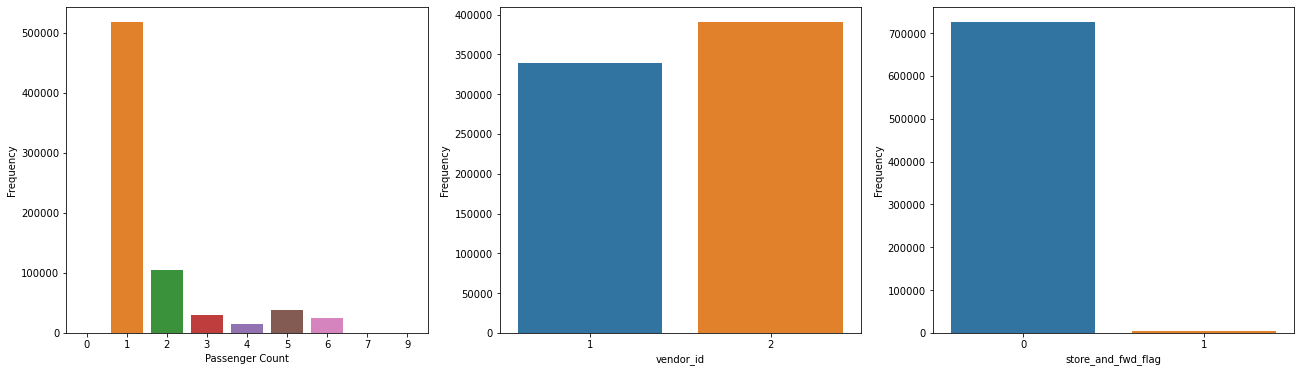

In [15]:
# Binary Features
plt.figure(figsize=(22, 6))
#fig, axs = plt.subplot(ncols=2)

# Passenger Count
plt.subplot(131)
sns.countplot(df['passenger_count'])
plt.xlabel('Passenger Count')
plt.ylabel('Frequency')


# vendor_id
plt.subplot(132)
sns.countplot(df['vendor_id'])
plt.xlabel('vendor_id')
plt.ylabel('Frequency')

# store_and_fwd_flag
plt.subplot(133)
sns.countplot(df['store_and_fwd_flag'])
plt.xlabel('store_and_fwd_flag')
plt.ylabel('Frequency')


Observations:
1. Most of the trips involve only 1 passenger. There are trips with 7-9 passengers but they are very low in number.
2. Vendor 2 has more number of trips as compared to vendor 1
3. The store_and_fwd_flag values, indicating whether the trip data was sent immediately to the vendor (“0”) or held in the memory of the taxi because there was no connection to the server (“1”), show that there was almost no storing taking place

Now, we will delve into the datetime features to understand the trend of number of hourly/monthly/daily taxi trips 

In [16]:
df['pickup_datetime'].min(), df['pickup_datetime'].max()

(Timestamp('2016-01-01 00:01:14'), Timestamp('2016-06-30 23:59:37'))

Clearly, These trips are for first 6 months of 2016. To look at trends, we first need to extract week days and hour of day from the pickup date.

In [17]:
df['day_of_week'] = df['pickup_datetime'].dt.weekday
df['hour_of_day'] = df['pickup_datetime'].dt.hour

Text(0, 0.5, 'Total number of pickups')

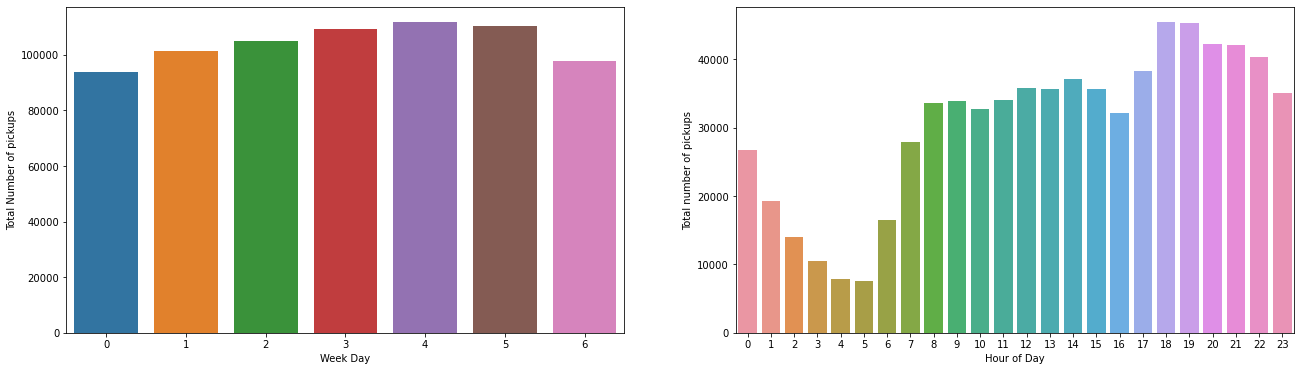

In [18]:

# Datetime features
plt.figure(figsize=(22, 6))

# Passenger Count
plt.subplot(121)
sns.countplot(df['day_of_week'])
plt.xlabel('Week Day')
plt.ylabel('Total Number of pickups')

# vendor_id
plt.subplot(122)
sns.countplot(df['hour_of_day'])
plt.xlabel('Hour of Day')
plt.ylabel('Total number of pickups')


* Number of pickups for weekends is much lower than week days with a peak on Thursday (4). Note that here weekday is a decimal number, where 0 is Sunday and 6 is Saturday.
* Number of pickups as expected is highest in late evenings. However, it is much lower during the morning peak hours.

### Lattitude & Longitude

Lets look at the geospatial or location features to check consistency. They should not vary much as we are only considering trips within New York city.

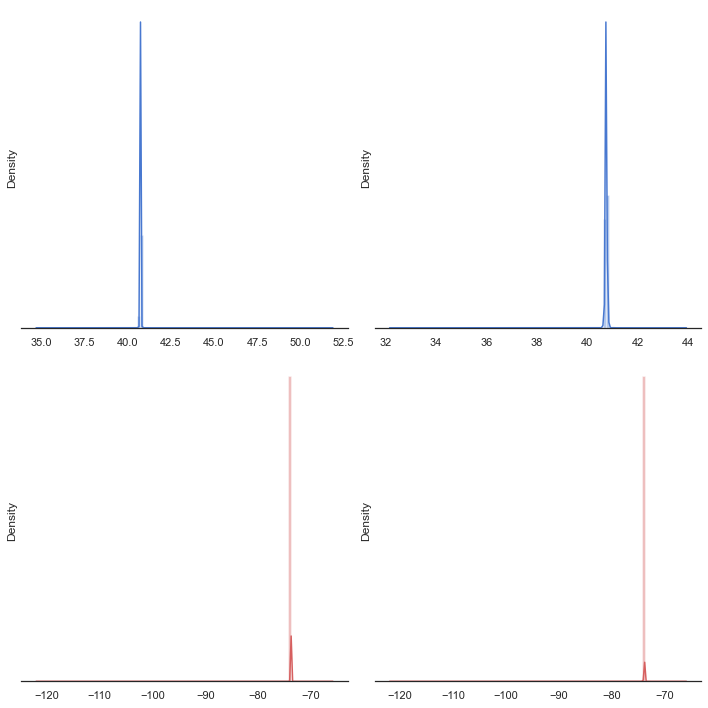

In [19]:
sns.set(style="white", palette="muted", color_codes=True)
f, axes = plt.subplots(2,2,figsize=(10, 10), sharex=False, sharey = False)
sns.despine(left=True)
sns.distplot(df['pickup_latitude'].values, label = 'pickup_latitude',color="b",bins = 100, ax=axes[0,0])
sns.distplot(df['pickup_longitude'].values, label = 'pickup_longitude',color="r",bins =100, ax=axes[1,0])
sns.distplot(df['dropoff_latitude'].values, label = 'dropoff_latitude',color="b",bins =100, ax=axes[0,1])
sns.distplot(df['dropoff_longitude'].values, label = 'dropoff_longitude',color="r",bins =100, ax=axes[1,1])
plt.setp(axes, yticks=[])
plt.tight_layout()
plt.show()

Findings - (Here, red represents pickup and dropoff Longitudes & blue represents pickup & dropoff lattitudes)

1. From the plot above it is clear that pick and drop latitude are centered around 40 to 41, and longitude are situated around -74 to -73. 
2. Some extreme co-ordinates has squeezed the plot such that we see a spike here
3. A good idea is to remove these outliers and look at the distribution more closely

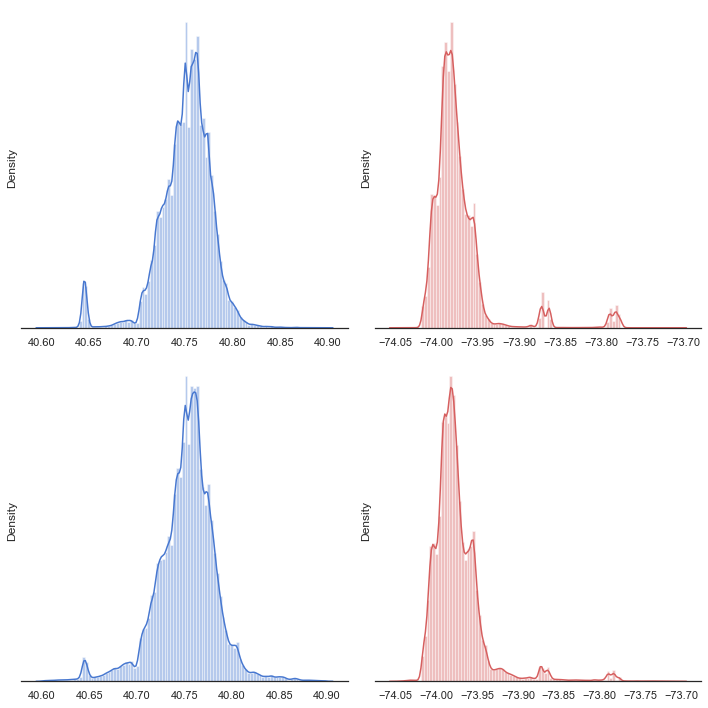

In [20]:
df = df.loc[(df.pickup_latitude > 40.6) & (df.pickup_latitude < 40.9)]
df = df.loc[(df.dropoff_latitude>40.6) & (df.dropoff_latitude < 40.9)]
df = df.loc[(df.dropoff_longitude > -74.05) & (df.dropoff_longitude < -73.7)]
df = df.loc[(df.pickup_longitude > -74.05) & (df.pickup_longitude < -73.7)]
df_data_new = df.copy()
sns.set(style="white", palette="muted", color_codes=True)
f, axes = plt.subplots(2,2,figsize=(10, 10), sharex=False, sharey = False)#
sns.despine(left=True)
sns.distplot(df_data_new['pickup_latitude'].values, label = 'pickup_latitude',color="b",bins = 100, ax=axes[0,0])
sns.distplot(df_data_new['pickup_longitude'].values, label = 'pickup_longitude',color="r",bins =100, ax=axes[0,1])
sns.distplot(df_data_new['dropoff_latitude'].values, label = 'dropoff_latitude',color="b",bins =100, ax=axes[1, 0])
sns.distplot(df_data_new['dropoff_longitude'].values, label = 'dropoff_longitude',color="r",bins =100, ax=axes[1, 1])
plt.setp(axes, yticks=[])
plt.tight_layout()

plt.show()

* We have a much better view of the distribution of coordinates instead of spikes. And we see that most trips are concentrated between these lat long only with a few significant clusters.
* These clusters are represented by the numerous peaks in the lattitude and longitude histograms


### Bivariate Relations with Target
Now that we have gone through all the basic features one by one. Let us start looking at their relation with the target. This will help us in selecting and extracting features at the modelling stage.

In [56]:
df.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'check_trip_duration', 'day_of_week', 'hour_of_day'],
      dtype='object')

### Trip Duration vs Weekday

For different week days, the trip durations can vary as different week days might have different traffic densities especially the weekends might have a much different patterns as compared to working days. Weekday is taken as a decimal number, where 0 - Sunday and 6 is Saturday.

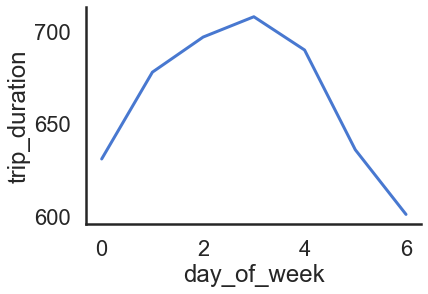

In [57]:
summary_wdays_avg_duration = pd.DataFrame(df.groupby(['day_of_week'])['trip_duration'].median())
summary_wdays_avg_duration.reset_index(inplace = True)
summary_wdays_avg_duration['unit']=1

sns.set(style="white", palette="muted", color_codes=True)
sns.set_context("poster")
sns.lineplot(data=summary_wdays_avg_duration, x="day_of_week", y="trip_duration")
sns.despine(bottom = False)

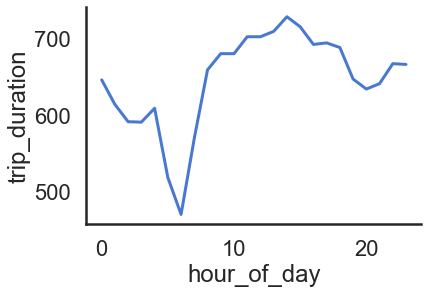

In [31]:

summary_hourly_avg_duration = pd.DataFrame(df.groupby(['hour_of_day'])['trip_duration'].median())
summary_hourly_avg_duration.reset_index(inplace = True)
summary_hourly_avg_duration['unit']=1

sns.set(style="white", palette="muted", color_codes=True)
sns.set_context("poster")
sns.lineplot(data=summary_hourly_avg_duration, x="hour_of_day", y="trip_duration")
#sns.tsplot(data=summary_hourly_avg_duration, time="hour_of_day", unit = "unit", value="trip_duration")
sns.despine(bottom = False)



* Trip durations are definitely shorter for late night and early morning hours that can be attributed to low traffic density
* It follows a similar pattern when compared to number of pickups indicating a correlation between number of pickups and trip duration

### vendor_id vs Trip Duration

Let's check how the trip duration varies for different vendors.

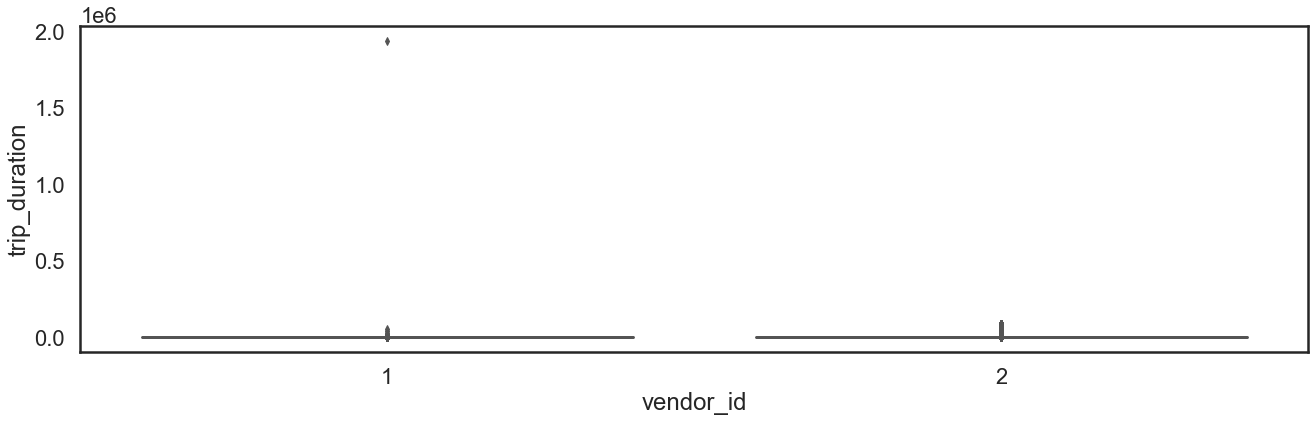

In [32]:
plt.figure(figsize=(22, 6))
sns.boxplot(x="vendor_id", y="trip_duration", data=df)
plt.show()

Woah! This did not come out as expected. The only thing I can see from this boxplot is that for vendor 2, there are a number of outliers exceeding 24 hours while vendor 1 does not have such long trips.

There could be 2 solutions to this:
1. Remove the huge outliers and plot again 
2. Look at median trip duration for both vendors on hourly basis

Let's try the first technique now and check trips below 50000 seconds only

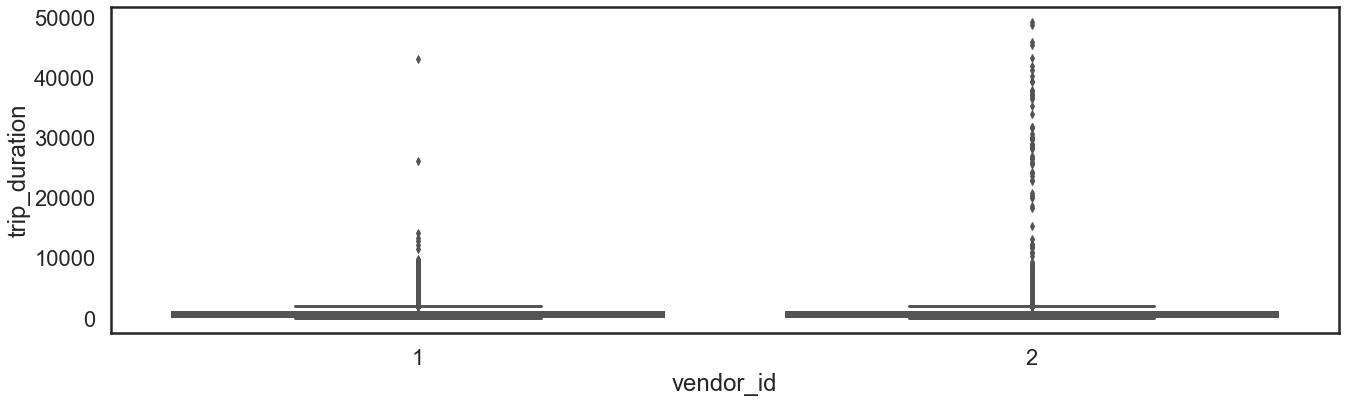

In [33]:
plt.figure(figsize=(22, 6))
df_sub = df[df['trip_duration'] < 50000]
sns.boxplot(x="vendor_id", y="trip_duration", data=df_sub)
plt.show()

As you can see, we were in a false perception earlier that vendor 1 had more outliers. Since the median is just around 600 seconds, we observe that vendor 2 has many more outliers as compared to vendor 1. Next, to confirm this, we will quickly look at the mean wrt day of week for both vendors using tsplot (time series plot) from seaborn.

### Mean Trip Duration Vendor Wise

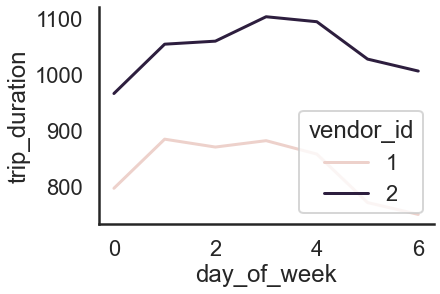

In [35]:
summary_wdays_avg_duration = pd.DataFrame(df.groupby(['vendor_id','day_of_week'])['trip_duration'].mean())
summary_wdays_avg_duration.reset_index(inplace = True)
summary_wdays_avg_duration['unit']=1

sns.set(style="white", palette="muted", color_codes=True)
sns.set_context("poster")
#sns.tsplot(data=summary_wdays_avg_duration, time="day_of_week", unit = "unit", condition="vendor_id", value="trip_duration")
sns.lineplot(data=summary_wdays_avg_duration, x="day_of_week", y="trip_duration",hue="vendor_id")
sns.despine(bottom = False)



### Median Trip Duration Vendor Wise

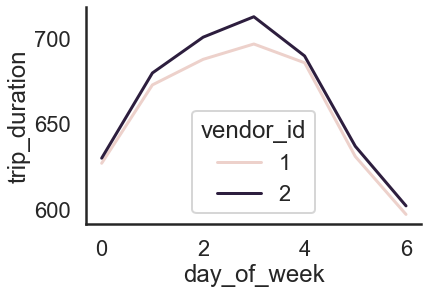

In [36]:
summary_wdays_avg_duration = pd.DataFrame(df.groupby(['vendor_id','day_of_week'])['trip_duration'].median())
summary_wdays_avg_duration.reset_index(inplace = True)
summary_wdays_avg_duration['unit']=1

sns.set(style="white", palette="muted", color_codes=True)
sns.set_context("poster")
#sns.tsplot(data=summary_wdays_avg_duration, time="day_of_week", unit = "unit", condition="vendor_id", value="trip_duration")
sns.lineplot(data=summary_wdays_avg_duration, x="day_of_week", y="trip_duration",hue="vendor_id")
sns.despine(bottom = False)



Median trip duration does not vary much as can be seen from the above plot for different vendors. It emphasises the importance of looking at the correct measure for central tendency for analysis.

### Trip Duration vs Passenger Count

Again as we are aware, there are a large number of outliers for trip duration and we will not be able to observe the differences. For this, we have taken a cutoff of 10000 seconds and used a boxplot.

In [37]:
df.passenger_count.value_counts()

1    515243
2    104576
5     38776
3     29561
6     24035
4     13972
0        31
9         1
Name: passenger_count, dtype: int64

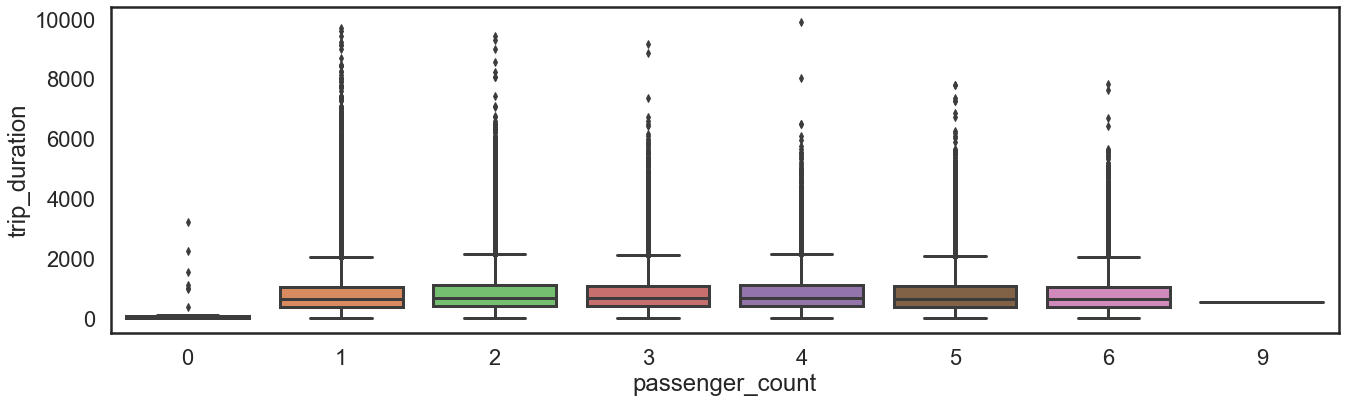

In [38]:
df.passenger_count.value_counts()
plt.figure(figsize=(22, 6))
df_sub = df[df['trip_duration'] < 10000]
sns.boxplot(x="passenger_count", y="trip_duration", data=df_sub)
plt.show()



* The boxplot clearly shows that there not much of a difference in distribution for the most frequently occuring passenger count values - 1, 2, 3.
* Another key observation is that the number of outliers are reduced for higher passenger counts but that only comes down to the individual frequencies of each passenger count.

### Visualise most frequently occuring Pickup points on the lattitude-longitude Map

Here, we try to visualise the most frequently occuring pickup points on the map and check how it is distributed spatially.

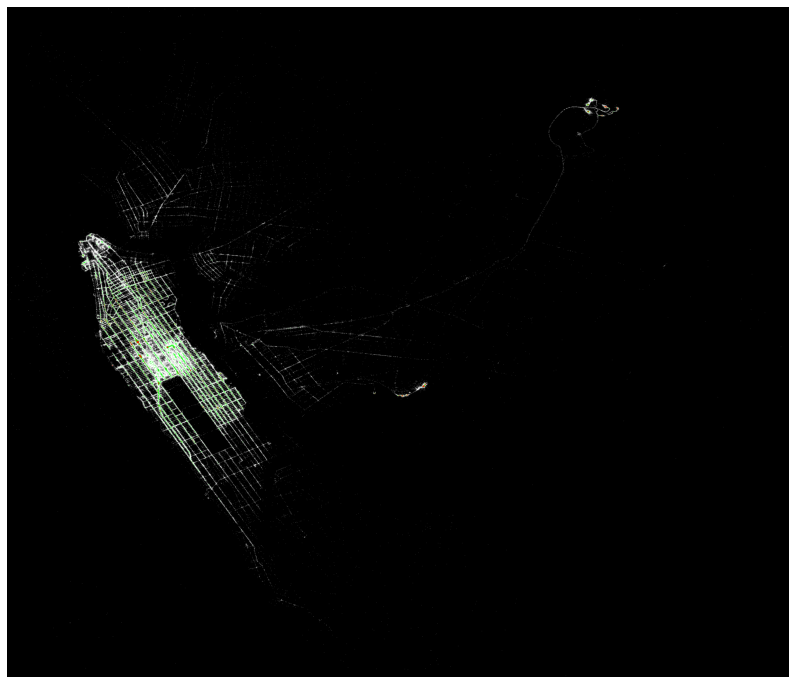

In [39]:

rgb = np.zeros((3000, 3500, 3), dtype=np.uint8)
rgb[..., 0] = 0
rgb[..., 1] = 0
rgb[..., 2] = 0
df_data_new['pick_lat_new'] = list(map(int, (df['pickup_latitude'] - (40.6000))*10000))
df_data_new['drop_lat_new'] = list(map(int, (df['dropoff_latitude'] - (40.6000))*10000))
df_data_new['pick_lon_new'] = list(map(int, (df['pickup_longitude'] - (-74.050))*10000))
df_data_new['drop_lon_new'] = list(map(int,(df['dropoff_longitude'] - (-74.050))*10000))

summary_plot = pd.DataFrame(df_data_new.groupby(['pick_lat_new', 'pick_lon_new'])['id'].count())

summary_plot.reset_index(inplace = True)
summary_plot.head(120)
lat_list = summary_plot['pick_lat_new'].unique()
for i in lat_list:
    lon_list = summary_plot.loc[summary_plot['pick_lat_new']==i]['pick_lon_new'].tolist()
    unit = summary_plot.loc[summary_plot['pick_lat_new']==i]['id'].tolist()
    for j in lon_list:
        a = unit[lon_list.index(j)]
        if (a//25) >0:
            rgb[i][j][0] = 255
            rgb[i,j, 1] = 0
            rgb[i,j, 2] = 0
        elif (a//10)>0:
            rgb[i,j, 0] = 0
            rgb[i,j, 1] = 255
            rgb[i,j, 2] = 0
        else:
            rgb[i,j, 0] = 255
            rgb[i,j, 1] = 255
            rgb[i,j, 2] = 255
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(14,20))
ax.imshow(rgb, cmap = 'hot')
ax.set_axis_off() 

Findings - From the heatmap kind of image above -

* White points - 1-10 trips have white as pickup point
* Green points - 10-25 trips have green as pickup point
* Red points - More than 25 trips have red as pickup point

As expected there are a few small clusters for hot pickup points as displayed by red in the above plot. Most pickup points have less than 10 trips and distributed all over the city.

If you go and have a look at an actual map of New York City, red and green points are mostly concentrated around the Manhatten Area

### Correlation Heatmap

Let us quickly look at the correlation heatmap to check the correlations amongst all features.

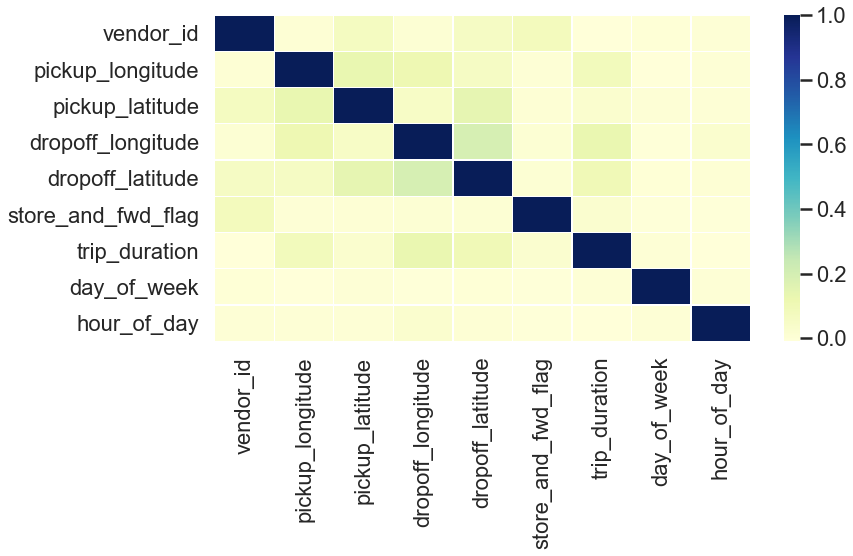

In [40]:
plt.figure(figsize=(12, 6))
df = df.drop(['id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count','check_trip_duration','log_trip_duration'],
        axis=1)
corr = df.apply(lambda x: pd.factorize(x)[0]).corr()
ax = sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, 
                 linewidths=.2, cmap="YlGnBu")

### Conclusions
1. The majority of rides follow a rather smooth distribution that looks almost log-normal with a peak just around exp(6.5)  i.e. about 17 minutes.
2. There are several suspiciously short rides with less than 10 seconds duration.
3. As discussed earlier, there are a few huge outliers near 12.
4. Most of the trips involve only 1 passenger. There are trips with 7-9 passengers but they are very low in number.
5. Vendor 2 has more number of trips as compared to vendor 1
6. Number of pickups for weekends is much lower than week days with a peak on Thursday (4). Note that here weekday is a decimal number, where 0 is Sunday and 6 is Saturday.
7. Number of pickups as expected is highest in late evenings. However, it is much lower during the morning peak hours.
8. We see that most trips are concentrated between these lat long only with a few significant clusters. These clusters are represented by the numerous peaks in the lattitude and longitude histograms
9. Trip durations are definitely shorter for late night and early morning hours that can be attributed to low traffic density
10. It follows a similar pattern when compared to number of pickups indicating a correlation between number of pickups and trip duration
11. Median trip duration does not vary much as can be seen from the above plot for different vendors.
12. The boxplot clearly shows that there not much of a difference in distribution for the most frequently occuring passenger count values - 1, 2, 3.
13. Another key observation is that the number of outliers are reduced for higher passenger counts but that only comes down to the individual frequencies of each passenger count.
14. From the correlation heatmap we see that the lattitude and longitude features have higher correlation with the target as compared to the other features.

## Feature Engineering Model Building using XGBoost (Gradient Boosting)


In [21]:
# Log transform the Y values
df_y = np.log1p(df['trip_duration'])

# Add some datetime features
df.loc[:, 'pickup_weekday'] = df['pickup_datetime'].dt.weekday
df.loc[:, 'pickup_hour_weekofyear'] = df['pickup_datetime'].dt.weekofyear
df.loc[:, 'pickup_hour'] = df['pickup_datetime'].dt.hour
df.loc[:, 'pickup_minute'] = df['pickup_datetime'].dt.minute
df.loc[:, 'pickup_dt'] = (df['pickup_datetime'] - df['pickup_datetime'].min()).dt.total_seconds()
df.loc[:, 'pickup_week_hour'] = df['pickup_weekday'] * 24 + df['pickup_hour']

### Feature Engineering

#### Eucledian Distance

In [22]:
#displacement
y_dist= df['pickup_longitude'] - df['dropoff_longitude']
x_dist = df['pickup_latitude'] - df['dropoff_latitude']

#square distance
df['dist_sq'] = (y_dist ** 2) + (x_dist ** 2)

#distance
df['dist_sqrt'] = df['dist_sq'] ** 0.5

#### Haversine Distance

In [23]:
def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

def direction_array(lat1, lng1, lat2, lng2):
    AVG_EARTH_RADIUS = 6371  # in km
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))


df['haversine_distance'] = haversine_array(df['pickup_latitude'].values, 
                                                     df['pickup_longitude'].values, 
                                                     df['dropoff_latitude'].values, 
                                                     df['dropoff_longitude'].values)


df['direction'] = direction_array(df['pickup_latitude'].values, 
                                          df['pickup_longitude'].values, 
                                          df['dropoff_latitude'].values, 
                                          df['dropoff_longitude'].values)

### Fastest route by road
Sometimes, adding external information can be crucial for improving the model. Here, we will use the dta extracted from The Open Source Routing Machine (OSRM) for each trip in our original dataset. OSRM is a C++ implementation of a high-performance routing engine for shortest paths in road networks. This will give us a very good estimate of distances between pickup and dropoff points.
Source:http://project-osrm.org

In [24]:
fr1 = pd.read_csv('fastest_routes_train_part_1.csv',
                  usecols=['id', 'total_distance', 'total_travel_time'])
fr2 = pd.read_csv('fastest_routes_train_part_2.csv',
                  usecols=['id', 'total_distance', 'total_travel_time'])

df_street_info = pd.concat((fr1, fr2))
df = df.merge(df_street_info, how='left', on='id')

df_street_info.head()

,id,total_distance,total_travel_time
0,id2875421,2009.1,164.9
1,id2377394,2513.2,332.0
2,id3504673,1779.4,235.8
3,id2181028,1614.9,140.1
4,id0801584,1393.5,189.4


### Binning
The latitide and longitude could be a bit noisy and it might be a good idea to bin then and create new features after rounding their values.

In [25]:
### Binned Coordinates ###
df['pickup_latitude_round3'] = np.round(df['pickup_latitude'],3)
df['pickup_longitude_round3'] = np.round(df['pickup_longitude'],3)

df['dropoff_latitude_round3'] = np.round(df['dropoff_latitude'],3)
df['dropoff_longitude_round3'] = np.round(df['dropoff_longitude'],3)

### Other Features

#### One Hot Encoding
Here Vendor Id can be converted to one hot encoding or frequency encoding since in the raw data, it has values of 1 and 2 without any inherent order.

In [26]:
df.vendor_id.value_counts()

2    388834
1    337361
Name: vendor_id, dtype: int64

Now, there is not much difference in the frequencies of both which may not make an important feature. So, we will just convert it to 0 and 1 by subtracting 1 from it.

In [27]:
df['vendor_id'] = df['vendor_id'] - 1

In [28]:
np.sum(pd.isnull(df))

id                          0
vendor_id                   0
pickup_datetime             0
dropoff_datetime            0
passenger_count             0
pickup_longitude            0
pickup_latitude             0
dropoff_longitude           0
dropoff_latitude            0
store_and_fwd_flag          0
trip_duration               0
check_trip_duration         0
day_of_week                 0
hour_of_day                 0
pickup_weekday              0
pickup_hour_weekofyear      0
pickup_hour                 0
pickup_minute               0
pickup_dt                   0
pickup_week_hour            0
dist_sq                     0
dist_sqrt                   0
haversine_distance          0
direction                   0
total_distance              1
total_travel_time           1
pickup_latitude_round3      0
pickup_longitude_round3     0
dropoff_latitude_round3     0
dropoff_longitude_round3    0
dtype: int64

In [29]:
# For a route, the total distance and travel time are not available. Let's impute that with 0
df.fillna(0, inplace = True)

In [30]:
df.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'check_trip_duration', 'day_of_week', 'hour_of_day',
       'pickup_weekday', 'pickup_hour_weekofyear', 'pickup_hour',
       'pickup_minute', 'pickup_dt', 'pickup_week_hour', 'dist_sq',
       'dist_sqrt', 'haversine_distance', 'direction', 'total_distance',
       'total_travel_time', 'pickup_latitude_round3',
       'pickup_longitude_round3', 'dropoff_latitude_round3',
       'dropoff_longitude_round3'],
      dtype='object')

Before we go on to build the model, we must drop the variables that should not be fed as features to the algorithms. We will drop 
* id - Uniquely represents a sample in the train set
* pickup_datetime - Since we have extracted the datetime features, there is no need to keep the datetime column
* dropoff_datetime - If this is used to create features, it would be a leakage and we will get perfect model performane. Why?   
  The time gap between dropoff_datetime and pickup_datetime is essentially what we are trying to predict
* trip_duration - This is the target variable and hence needs to be dropped
* store_and_fwd_flag - This variable is not available before the start of the trip and hence should not be used for modeling.


In [31]:
# We will drop the columns that are not useful for our model
df = df.drop(['id', 'pickup_datetime', 'dropoff_datetime', 'trip_duration','store_and_fwd_flag'], axis=1)

## Model Building

Now, before we go on to build the model, let us look at the dataset.

In [32]:
df.head()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,check_trip_duration,day_of_week,hour_of_day,pickup_weekday,...,dist_sq,dist_sqrt,haversine_distance,direction,total_distance,total_travel_time,pickup_latitude_round3,pickup_longitude_round3,dropoff_latitude_round3,dropoff_longitude_round3
0,1,1,-73.953918,40.778873,-73.963875,40.771164,400.0,0,16,0,...,0.000159,0.012592,1.199073,-135.634530,1630.9,172.5,40.779,-73.954,40.771,-73.964
1,0,2,-73.988312,40.731743,-73.994751,40.694931,1100.0,4,23,4,...,0.001397,0.037371,4.129111,-172.445217,5428.7,581.8,40.732,-73.988,40.695,-73.995
2,1,2,-73.997314,40.721458,-73.948029,40.774918,1635.0,6,17,6,...,0.005287,0.072712,7.250753,34.916093,9327.8,748.9,40.721,-73.997,40.775,-73.948
3,1,6,-73.961670,40.759720,-73.956779,40.780628,1141.0,1,9,1,...,0.000461,0.021473,2.361097,10.043567,8022.7,612.2,40.760,-73.962,40.781,-73.957
4,0,1,-74.017120,40.708469,-73.988182,40.740631,848.0,2,6,2,...,0.001872,0.043264,4.328534,34.280582,5468.7,645.0,40.708,-74.017,40.741,-73.988


### Defining metric

In [56]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from math import sqrt 

### Train and Test Data Split

In [34]:
#Splitting the data into df and Validation set
xtrain, xtest, ytrain, ytest = train_test_split(df,df_y,test_size=1/3, random_state=0)

### Mean Prediction
Before we go on to try a machine learning model, let us look at the performance of a basic model that just says the mean of the trip duration in the train data set is the prediction of all the trips in the test dataset. 

In [35]:
mean_pred = np.repeat(ytrain.mean(),len(ytest))
sqrt(mean_squared_error(ytest,mean_pred ))

0.7881389476650525

### Cross validation
Cross validation is one of the most important concepts in any type of data modeling. It simple says, try to leave a sample on which you do not train the model and test the model on this sample before finalizing the model.

We will divide the entire population into k equal samples. Now, we train the models on k-1 samples and perform validation on 1 sample. Then, at the second iteration, we train the model with  a different sample held as validation.

In k iterations, we have basically built a model on each sample and held each of them as validation. this is a way to reduce the selection bias and reduce the variance in prediction power.

In [47]:
from math import sqrt
def cv_score(ml_model, rstate = 11,cols = df.columns):
    i = 1
    cv_scores = []
    df1 = df.copy()
    df1 = df[cols]
    
    kf = KFold(n_splits=5,random_state=rstate,shuffle=True)
    for train_index,test_index in kf.split(df1,df_y):
        print('\n{} of kfold {}'.format(i,kf.n_splits))
        xtr,xvl = df1.loc[train_index].values,df1.loc[test_index].values
        ytr,yvl = df_y[train_index].values,df_y[test_index].values

        model = ml_model
        model.fit(xtr, ytr)
        train_val = model.predict(xtr)
        pred_val = model.predict(xvl)
        rmse_score_train = sqrt(mean_squared_error(ytr, train_val))
        rmse_score = sqrt(mean_squared_error(yvl, pred_val))
        sufix = ""
        msg = ""
        #msg += "Train RMSE: {:.5f} ".format(rmse_score_train)
        msg += "Valid RMSE: {:.5f}".format(rmse_score)
        print("{}".format(msg))
        # Save scores
        cv_scores.append(rmse_score)
        i+=1
    return cv_scores

## XGBoost

* First we will set the  hyperparameters for XGBoost and use cross validation to track and figure out the correct number of rounds so that it does not overfit.

* Later, we will fit the XGBoost Regressor using the number of rounds identified from the above step and check the cross validation scores

To find the approximate number of rounds for XGBoost, we will first create a validation set and check performance after each round.


* We will convert the dataset into an optimized data structure called DMatrix that XGBoost supports and gives it acclaimed performance and efficiency gains

In [66]:
data_dmatrix = xgb.DMatrix(data=df,label=df_y)
dtrain = xgb.DMatrix(xtrain, label=ytrain)
dvalid = xgb.DMatrix(xtest, label=ytest)

watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

Finally! We're ready to use XGBoost. You'll notice that this part is actually quite short. But only in code. It can take quite a while to iterate through the different parameters and different values of these parameters to better the outcome of the model. There are several ways to do this and we will cover this in a later module.

In [42]:
xgb_params = {}
xgb_params["objective"] = "reg:linear"
xgb_params['eval_metric'] = "rmse"
xgb_params["eta"] = 0.05
xgb_params["min_child_weight"] = 10
xgb_params["subsample"] = 0.9
xgb_params["colsample_bytree"] = 0.7
xgb_params["max_depth"] = 5
xgb_params['silent'] = 1
xgb_params["seed"] = 2019
xgb_params["nthread"] = -1
xgb_params["lambda"] = 2

xgb_model = xgb.train(xgb_params, dtrain, 5000, watchlist, early_stopping_rounds=50,
      maximize=False, verbose_eval=20)
print('Modeling RMSE %.5f' % xgb_model.best_score)

[14:17:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[14:17:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-rmse:5.71449	valid-rmse:5.71551
[20]	train-rmse:2.05636	valid-rmse:2.05680
[40]	train-rmse:0.74751	valid-rmse:0.74780
[60]	train-rmse:0.27781	valid-rmse:0.27801
[80]	train-rmse:0.10986	valid-rmse:0.11001
[100]	train-rmse:0.05543	valid-rmse:0.05562
[120]	train-rmse:0.03833	valid-rmse:0.03855
[140]	train-rmse:0.02951	valid-rmse:0.02975
[160]	train-rmse:0.02471	valid-rmse:0.02494
[180]	train-rmse:0.02149	valid-rmse:0.02174
[20

[3420]	train-rmse:0.00511	valid-rmse:0.00727
[3440]	train-rmse:0.00509	valid-rmse:0.00726
[3460]	train-rmse:0.00508	valid-rmse:0.00726
[3480]	train-rmse:0.00507	valid-rmse:0.00726
[3500]	train-rmse:0.00506	valid-rmse:0.00725
[3520]	train-rmse:0.00505	valid-rmse:0.00724
[3540]	train-rmse:0.00504	valid-rmse:0.00724
[3560]	train-rmse:0.00503	valid-rmse:0.00724
[3580]	train-rmse:0.00502	valid-rmse:0.00724
[3600]	train-rmse:0.00502	valid-rmse:0.00723
[3620]	train-rmse:0.00500	valid-rmse:0.00722
[3640]	train-rmse:0.00499	valid-rmse:0.00721
[3660]	train-rmse:0.00498	valid-rmse:0.00721
[3680]	train-rmse:0.00497	valid-rmse:0.00720
[3700]	train-rmse:0.00496	valid-rmse:0.00720
[3720]	train-rmse:0.00495	valid-rmse:0.00719
[3740]	train-rmse:0.00494	valid-rmse:0.00719
[3760]	train-rmse:0.00494	valid-rmse:0.00719
[3780]	train-rmse:0.00493	valid-rmse:0.00718
[3800]	train-rmse:0.00492	valid-rmse:0.00718
[3820]	train-rmse:0.00491	valid-rmse:0.00717
[3840]	train-rmse:0.00490	valid-rmse:0.00716
[3860]	tra

Now, we can investigate the importance of each feature, to understand what affects the trip duration the most significantly. Here's how XGBoost allows us to do it:

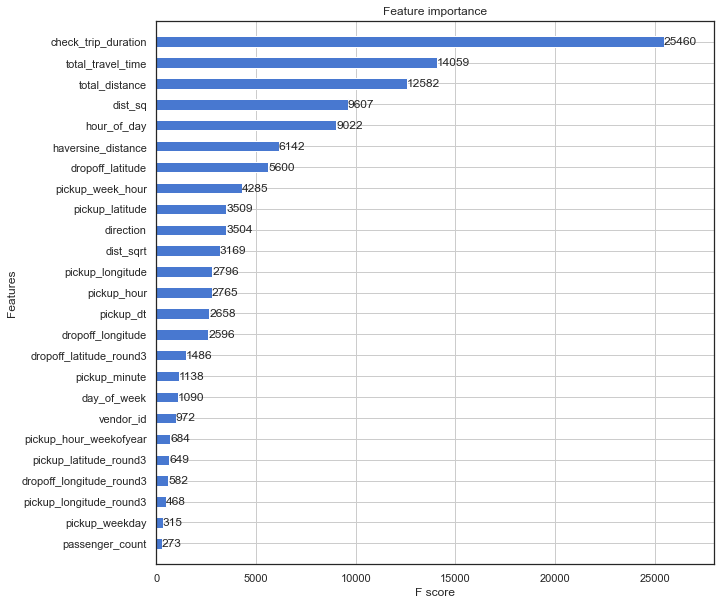

In [43]:
ax = xgb.plot_importance(xgb_model, max_num_features=28, height=0.5)
fig = ax.figure
fig.set_size_inches(10, 10)

So from top to bottom we see which features have the greatest effect on trip duration. It makes logical sense that the lattitude and longitude have high impact on predicting the trip duration. The further you travel, the longer it'll take. 

Remember that this is one way of looking at importance of features and it only signifies how important is a variable for XGBoost while fitting the training set.

* The next step is to instantiate an XGBoost regressor object by calling the XGBRegressor() class from the XGBoost library with the hyper-parameters passed as arguments. For classification problems, you would have used the XGBClassifier() class.

In [59]:
xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)

* Fit the regressor to the training set and make predictions on the test set using the familiar .fit() and .predict() methods.

In [60]:
xg_reg.fit(xtrain,ytrain)

[16:34:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.3, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=5,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=10, n_jobs=8, num_parallel_tree=1,
             objective='reg:linear', random_state=0, reg_alpha=10, reg_lambda=1,
             scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [61]:
preds = xg_reg.predict(xtest)

In [75]:
preds = [round(value) for value in preds]

* Compute the rmse by invoking the mean_sqaured_error function from sklearn's metrics module.

In [65]:
rmse = np.sqrt(mean_squared_error(ytest, preds))
print("RMSE: %f" % (rmse))

RMSE: 2.133359


### k-fold Cross Validation using XGBoost
In order to build more robust models, it is common to do a k-fold cross validation where all the entries in the original training dataset are used for both training as well as validation. Also, each entry is used for validation just once. XGBoost supports k-fold cross validation via the cv() method. All you have to do is specify the nfolds parameter, which is the number of cross validation sets you want to build. Also, it supports many other parameters (check out this link) like:

* num_boost_round: denotes the number of trees you build (analogous to n_estimators)
* metrics: tells the evaluation metrics to be watched during CV
* as_pandas: to return the results in a pandas DataFrame.
* early_stopping_rounds: finishes training of the model early if the hold-out metric ("rmse" in our case) does not improve for a   given number of rounds.
* seed: for reproducibility of results.

This time you will create a hyper-parameter dictionary params which holds all the hyper-parameters and their values as key-value pairs but will exclude the n_estimators from the hyper-parameter dictionary because you will use num_boost_rounds instead.

You will use these parameters to build a 3-fold cross validation model by invoking XGBoost's cv() method and store the results in a cv_results DataFrame. Note that here you are using the Dmatrix object you created before.

In [69]:
params = {"objective":"reg:linear",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}

cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=3,
                    num_boost_round=50,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=123)

[16:54:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[16:54:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[16:54:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.


* cv_results contains train and test RMSE metrics for each boosting round.

In [70]:
cv_results.head()

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,5.414134,0.000736,5.414152,0.001463
1,4.875261,0.001658,4.875240,0.002325
2,4.388932,0.000653,4.388934,0.001085
3,3.952506,0.001244,3.952526,0.002417
4,3.559876,0.001907,3.559922,0.001739


* Extract and print the final boosting round metric.

In [71]:
print((cv_results["test-rmse-mean"]).tail(1))

49    0.117044
Name: test-rmse-mean, dtype: float64
